In [9]:
import h5py
import numpy as np
from synthesizer.conversions import lnu_to_absolute_mag
import pandas as pd
import unyt
from unyt import erg, Hz, s
import cmasher as cmr
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import sys
sys.path.append("/disk/xray15/aem2/camels/proj2")
from setup_params import get_photometry, get_luminosity_function, get_colour_distribution

# Base directories
base_dir = "/disk/xray15/aem2/data/28pams/IllustrisTNG/1P"
input_dir = f"{base_dir}/photometry"

# Redshift mappings
redshift_values = {
    '044': {'redshift': 2.00, 'label': 'z2.0'},
    '052': {'redshift': 1.48, 'label': 'z1.5'},
    '060': {'redshift': 1.05, 'label': 'z1.0'},
    '086': {'redshift': 0.10, 'label': 'z0.1'}
}

# Output directories
lf_output_dir = {
    "observed": {
        "GALEX": f"{base_dir}/LFs/observed/GALEX"  # Attenuated GALEX
    },
    "restframe": {
        "UV1500": f"{base_dir}/LFs/restframe/UV1500",  # Pure rest-frame
        "GALEX": f"{base_dir}/LFs/restframe/GALEX"     # Rest-frame through GALEX filters
    }
}

colour_output_dir = {
    "observed": {
        "GALEX": f"{base_dir}/colours/observed/GALEX"
    },
    "restframe": {
        "GALEX": f"{base_dir}/colours/restframe/GALEX"
    }
}

# parameters
uvlf_limits = (-24, -16)
uvlf_nbins =11
colour_limits = (-0.5, 3.5)
colour_nbins = 20

# magnitude limits (DIS) from https://iopscience.iop.org/article/10.1086/520512/pdf
NUV_mag_lim = 24.4
FUV_mag_lim = 24.8


# GALEX magnitude limits
mag_limits = {
    "GALEX FUV": 24.8,  # From https://iopscience.iop.org/article/10.1086/520512/pdf
    "GALEX NUV": 24.4
}

# Filter definitions
filters = {
    "restframe": ["UV1500", "GALEX FUV", "GALEX NUV"],
    "observed": ["GALEX FUV", "GALEX NUV"]
}

# directories including redshift subdirectories
for category in ["observed", "restframe"]:
    for filters, path in lf_output_dir[category].items():
        for redshift_info in redshift_values.values():
            redshift_dir = os.path.join(path, redshift_info['label'])
            os.makedirs(redshift_dir, exist_ok=True)
            
    for filters, path in colour_output_dir[category].items():
        for redshift_info in redshift_values.values():
            redshift_dir = os.path.join(path, redshift_info['label'])
            os.makedirs(redshift_dir, exist_ok=True)




In [10]:
def get_restframe_uvlf(sim_name, snap, filters):
    """Get rest-frame luminosity function for given filters"""
    photo = get_photometry(
        sim_name=sim_name,
        spec_type="intrinsic",
        snap=snap,
        sps="BC03",
        model="IllustrisTNG",
        filters=filters,
        photo_dir=input_dir
    )
    return photo

def get_attenuated_uvlf(sim_name, snap, filters):
    """Get attenuated luminosity function for given filters"""
    photo = get_photometry(
        sim_name=sim_name,
        spec_type="attenuated",
        snap=snap,
        sps="BC03",
        model="IllustrisTNG",
        filters=filters,
        photo_dir=input_dir
    )
    return photo

def get_colour_dist(photo, filtA, filtB, mag_limits=None):
    """Get colour distribution using Chris's approach"""
    if mag_limits:
        # Create magnitude masks if limits provided
        maskA = photo[filtA] < mag_limits[filtA]
        maskB = photo[filtB] < mag_limits[filtB]
        combined_mask = maskA & maskB
    else:
        combined_mask = None
        
    colour_dist, bin_lims = get_colour_distribution(
        photo,
        filtA,
        filtB,
        *colour_limits,  # Using global colour_limits
        n_bins=colour_nbins,
        mask=combined_mask
    )
    return colour_dist, bin_lims



Processing rest-frame data...

Processing attenuated data...


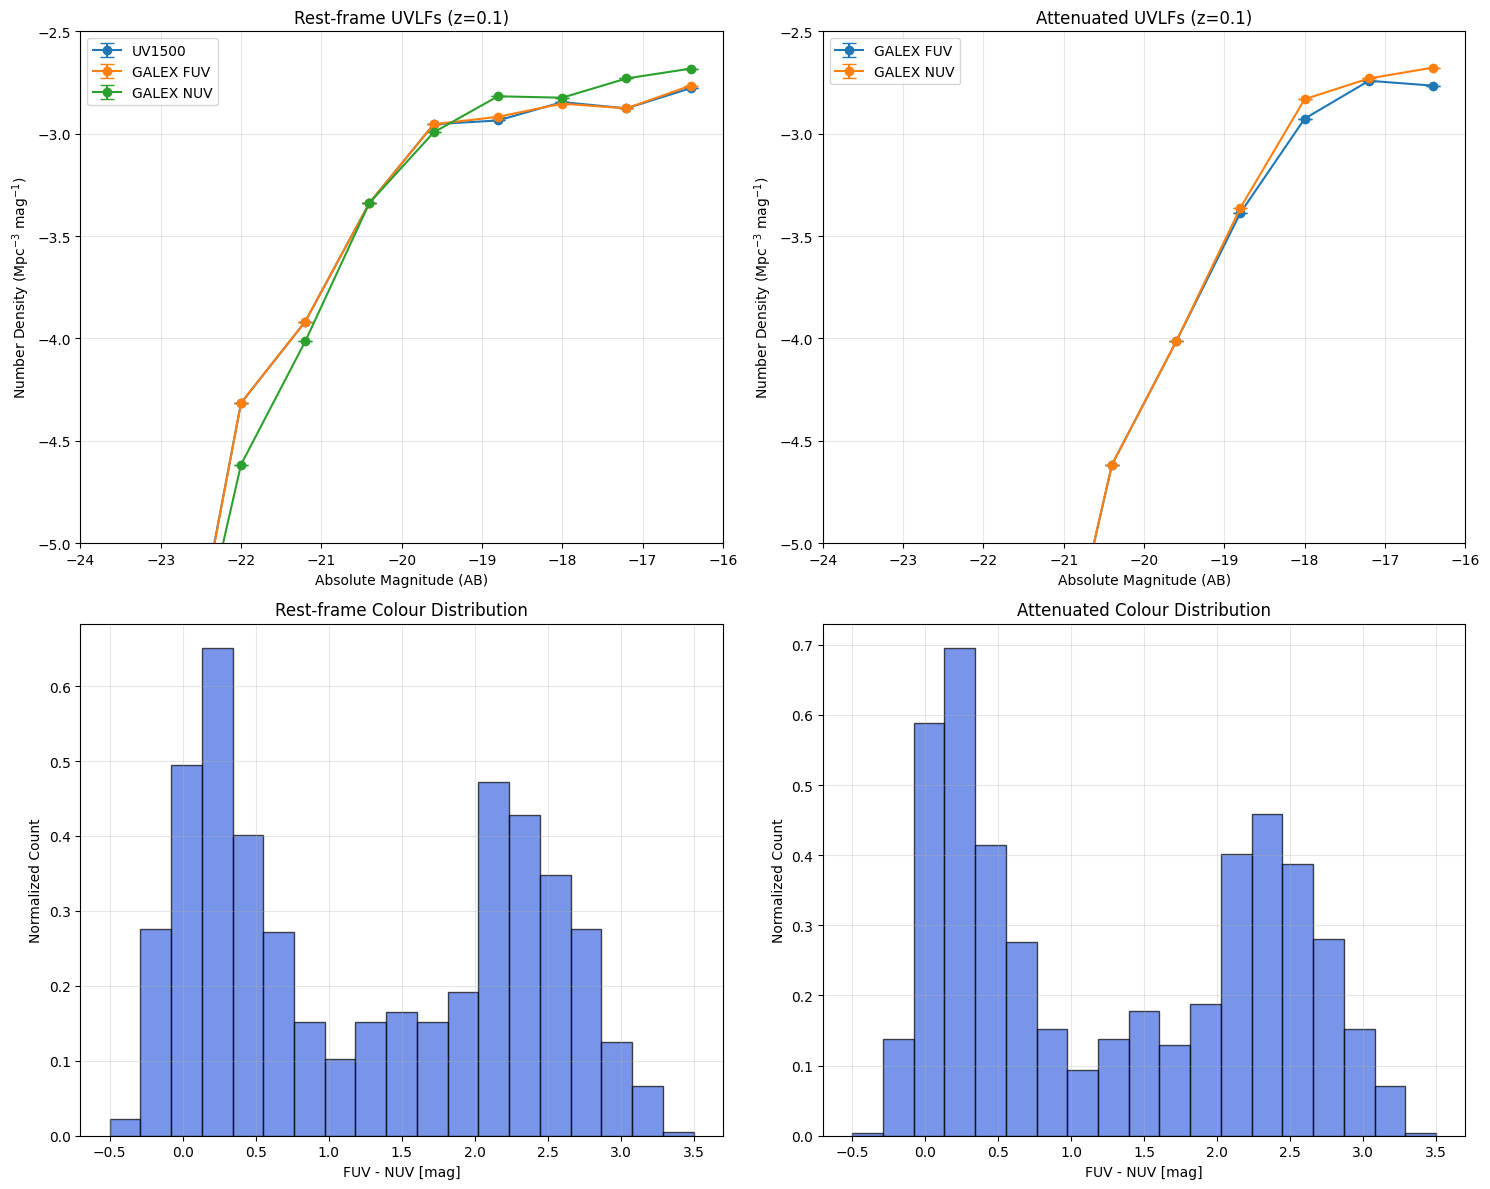

In [11]:

def test_single_file(sim_name, snap):
    """Test processing for a single file"""
    
    # Test rest-frame
    print("\nProcessing rest-frame data...")
    rest_photo = get_restframe_uvlf(sim_name, snap, ["UV1500", "GALEX FUV", "GALEX NUV"])
    
    # Calculate UVLFs
    rest_uvlfs = {}
    for filt in rest_photo:
        phi, phi_sigma, hist, bin_lims = get_luminosity_function(
            rest_photo,
            filt,
            *uvlf_limits,
            n_bins=uvlf_nbins
        )
        rest_uvlfs[filt] = (phi, phi_sigma, hist, bin_lims)
    
    # Calculate rest-frame GALEX colours
    rest_colours = {}
    if "GALEX FUV" in rest_photo and "GALEX NUV" in rest_photo:
        colour_dist, bin_lims = get_colour_dist(
            rest_photo, 
            "GALEX FUV", 
            "GALEX NUV",
            mag_limits={"GALEX FUV": FUV_mag_lim, "GALEX NUV": NUV_mag_lim}
        )
        rest_colours["FUV-NUV"] = (colour_dist, bin_lims)
    
    # Test attenuated
    print("\nProcessing attenuated data...")
    att_photo = get_attenuated_uvlf(sim_name, snap, ["GALEX FUV", "GALEX NUV"])
    
    # Calculate UVLFs
    att_uvlfs = {}
    for filt in att_photo:
        phi, phi_sigma, hist, bin_lims = get_luminosity_function(
            att_photo,
            filt,
            *uvlf_limits,
            n_bins=uvlf_nbins
        )
        att_uvlfs[filt] = (phi, phi_sigma, hist, bin_lims)
    
    # Calculate attenuated colours
    att_colours = {}
    colour_dist, bin_lims = get_colour_dist(
        att_photo, 
        "GALEX FUV", 
        "GALEX NUV",
        mag_limits={"GALEX FUV": FUV_mag_lim, "GALEX NUV": NUV_mag_lim}
    )
    att_colours["FUV-NUV"] = (colour_dist, bin_lims)
    
    # Plot results
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot rest-frame UVLFs
    for filt, (phi, phi_sigma, hist, bin_lims) in rest_uvlfs.items():
        bin_centers = 0.5 * (bin_lims[1:] + bin_lims[:-1])
        ax1.errorbar(bin_centers, phi, yerr=phi_sigma, 
                    fmt='o-', label=filt, capsize=5)
    #uvlf_limits = (-24, -16)
    ax1.set_ylim(-5, -2.5)
    ax1.set_xlim(-24, -16)
    ax1.set_xlabel('Absolute Magnitude (AB)')
    ax1.set_ylabel('Number Density (Mpc$^{-3}$ mag$^{-1}$)')
    ax1.set_title(f'Rest-frame UVLFs (z={redshift_values[snap]["redshift"]})')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot attenuated UVLFs
    for filt, (phi, phi_sigma, hist, bin_lims) in att_uvlfs.items():
        bin_centers = 0.5 * (bin_lims[1:] + bin_lims[:-1])
        ax2.errorbar(bin_centers, phi, yerr=phi_sigma, 
                    fmt='o-', label=filt, capsize=5)
    ax2.set_ylim(-5, -2.5)
    ax2.set_xlim(-24, -16)
    ax2.set_xlabel('Absolute Magnitude (AB)')
    ax2.set_ylabel('Number Density (Mpc$^{-3}$ mag$^{-1}$)')
    ax2.set_title(f'Attenuated UVLFs (z={redshift_values[snap]["redshift"]})')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Plot rest-frame colours
    for colour_name, (dist, bins) in rest_colours.items():
        bin_centers = 0.5 * (bins[1:] + bins[:-1])
        ax3.hist(bin_centers, bins=bins, weights=dist,
                alpha=0.7, color='royalblue', edgecolor='black')
    ax3.set_xlabel('FUV - NUV [mag]')
    ax3.set_ylabel('Normalized Count')
    ax3.set_title('Rest-frame Colour Distribution')
    ax3.grid(True, alpha=0.3)
    
    # Plot attenuated colours
    for colour_name, (dist, bins) in att_colours.items():
        bin_centers = 0.5 * (bins[1:] + bins[:-1])
        ax4.hist(bin_centers, bins=bins, weights=dist,
                alpha=0.7, color='royalblue', edgecolor='black')
    ax4.set_xlabel('FUV - NUV [mag]')
    ax4.set_ylabel('Normalized Count')
    ax4.set_title('Attenuated Colour Distribution')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return rest_photo, att_photo

if __name__ == "__main__":
    rest_photo, att_photo = test_single_file(sim_name="1P_p1_0", snap="086")

In [12]:
def process_data(category, bands, colour_pairs=None):
    """Process data for any combination of bands and color pairs"""
    photo_files = [f for f in os.listdir(input_dir) if f.endswith('_photometry.hdf5')]
    
    for filename in photo_files:
        sim_name = filename.replace('IllustrisTNG_', '').replace('_photometry.hdf5', '')
        print(f"\nProcessing {sim_name}")
        
        for snap, redshift_info in redshift_values.items():
            print(f"  Processing z={redshift_info['label']}")
            
            # Get photometry
            photo = get_photometry(
                sim_name=sim_name,
                spec_type="intrinsic" if category == "restframe" else "attenuated",
                snap=snap,
                sps="BC03",
                model="IllustrisTNG",
                filters=bands,
                photo_dir=input_dir
            )
            
            # Process UVLFs
            for band in bands:
                phi, phi_sigma, hist, bin_lims = get_luminosity_function(
                    photo,
                    band,
                    *uvlf_limits,
                    n_bins=uvlf_nbins
                )
                
                # Save UVLF
                bin_centers = 0.5 * (bin_lims[1:] + bin_lims[:-1])
                uvlf_df = pd.DataFrame({
                    'magnitude': bin_centers,
                    'phi': phi,
                    'phi_sigma': phi_sigma,
                    'hist': hist
                })
                
                # Determine output directory based on band type
                if band == "UV1500":
                    output_dir = os.path.join(lf_output_dir["restframe"]["UV1500"],
                                            redshift_info['label'])
                else:
                    output_dir = os.path.join(lf_output_dir[category]["GALEX"],
                                            redshift_info['label'])
                
                spec_type = "intrinsic" if category == "restframe" else "attenuated"
                uvlf_filename = f"UVLF_{sim_name}_{band}_{redshift_info['label']}_{spec_type}.txt"
                uvlf_df.to_csv(os.path.join(output_dir, uvlf_filename), 
                             index=False, sep='\t')
            
            # Process colours if pairs provided
            if colour_pairs:
                for band1, band2 in colour_pairs:
                    if band1 in photo and band2 in photo:
                        # Create masks for magnitude limits
                        masks = {
                            band: photo[band] < mag_limits[band]
                            for band in [band1, band2]
                            if band in mag_limits  # Only apply limits to GALEX bands
                        }
                        
                        if masks:  # If we have any magnitude limits
                            combined_mask = np.ones(len(photo[band1]), dtype=bool)
                            for mask in masks.values():
                                combined_mask &= mask
                        else:
                            combined_mask = None

                        colour_dist, bin_lims = get_colour_distribution(
                            photo,
                            band1,
                            band2,
                            *colour_limits,
                            n_bins=colour_nbins,
                            mask=combined_mask
                        )
                        
                        bin_centers = 0.5 * (bin_lims[1:] + bin_lims[:-1])
                        colour_df = pd.DataFrame({
                            'colour': bin_centers,
                            'distribution': colour_dist
                        })

                        # Save colours
                        output_dir = os.path.join(colour_output_dir[category]["GALEX"],
                                                redshift_info['label'])
                        
                        spec_type = "intrinsic" if category == "restframe" else "attenuated"
                        colour_filename = f"Colour_{sim_name}_FUV-NUV_{redshift_info['label']}_{spec_type}.txt"
                        colour_df.to_csv(os.path.join(output_dir, colour_filename),
                                       index=False, sep='\t')

            print(f"    Completed processing for z={redshift_info['label']}")

if __name__ == "__main__":
    # Test one parameter variation first
    test_files = ["1P_p1_0"]
    
    # GALEX data
    print("\nTesting GALEX processing...")
    galex_bands = ["GALEX FUV", "GALEX NUV"]
    galex_colours = [("GALEX FUV", "GALEX NUV")]
    process_data("observed", galex_bands, galex_colours)
    process_data("restframe", galex_bands, galex_colours)
    
    # Rest-frame wavelengths
    print("\nTesting rest-frame wavelength processing...")
    wavelengths = ["UV1500"]
    process_data("restframe", wavelengths)


Testing GALEX processing...

Processing 1P_p7_2
  Processing z=z2.0
    Completed processing for z=z2.0
  Processing z=z1.5
    Completed processing for z=z1.5
  Processing z=z1.0
    Completed processing for z=z1.0
  Processing z=z0.1
    Completed processing for z=z0.1

Processing 1P_p9_n1
  Processing z=z2.0
    Completed processing for z=z2.0
  Processing z=z1.5
    Completed processing for z=z1.5
  Processing z=z1.0
    Completed processing for z=z1.0
  Processing z=z0.1
    Completed processing for z=z0.1

Processing 1P_p14_n2
  Processing z=z2.0
    Completed processing for z=z2.0
  Processing z=z1.5
    Completed processing for z=z1.5
  Processing z=z1.0
    Completed processing for z=z1.0
  Processing z=z0.1
    Completed processing for z=z0.1

Processing 1P_p23_n1
  Processing z=z2.0
    Completed processing for z=z2.0
  Processing z=z1.5
    Completed processing for z=z1.5
  Processing z=z1.0
    Completed processing for z=z1.0
  Processing z=z0.1
    Completed processing f